# Metadata

```
Course:   DS 5001
Module:   08 HW
Topic:    Prepare OKCupid Corpus
Author:   R.C. Alvarado
```

# Set Up

In [1]:
data_home = '../data'
local_lib = '../lib'

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from nltk.tag import StanfordPOSTagger

# Import Corpus

In [3]:
src_file = '~/Dropbox/CODE/polo-pub/PUB/okcupid/corpus/profiles.csv'

In [4]:
OKC = pd.read_csv(src_file)
essay_cols = [col for col in OKC.columns if 'essay' in col]
OKC['doc_raw'] = OKC[essay_cols].apply(lambda x: ' '.join(x.values.astype(str)), axis=1)
OKC = OKC.drop(essay_cols, axis=1)
OKC['doc_clean'] = OKC.doc_raw.str.replace(r"<[^>]+>", "", regex=True)
OKC['doc_clean'] = OKC.doc_clean.str.replace(r'&[^&;]+;', ' ', regex=True)
OKC['doc_clean'] = OKC.doc_clean.str.replace(r"\n+", " ", regex=True)
OKC['doc_clean'] = OKC.doc_clean.str.replace(r"\W+", " ", regex=True)
OKC['doc_clean'] = OKC.doc_clean.str.replace(r"\s+", " ", regex=True)
OKC.index.name = 'doc_id'

In [5]:
OKC.to_csv("../data/okcupid/okcupid-DOC.csv", index=True)

# Balance and Reduce by Sex

In [6]:
OKC.loc[(OKC.income > 0) & (OKC.age > 0)].sex.value_counts()

m    8391
f    3113
Name: sex, dtype: int64

In [7]:
M = OKC.loc[(OKC.income > 0) & (OKC.sex=='m')].sample(3000)
F = OKC.loc[(OKC.income > 0) & (OKC.sex=='f')].sample(3000)
MF = pd.concat([M, F])

In [8]:
# MF

# Tokenize and Tag with Stanford CoreNLP

* See https://stanfordnlp.github.io/CoreNLP/corenlp-server.html 

In [9]:
from nltk.parse import CoreNLPParser
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords

In [10]:
# CoreNLPParser?

In [11]:
def tag_sents(SENTS):

    pos_tagger = CoreNLPParser(url='http://localhost:9000', tagtype='pos')

    input_sents = [sent.split() for sent in SENTS.values]
    parsed_sents = [pos_tagger.tag(sent) for sent in tqdm(input_sents)]

    TOKEN = pd.DataFrame(parsed_sents, index=SENTS.index).stack().to_frame()
    TOKEN['term_str'] = TOKEN[0].apply(lambda x: x[0], 1)
    TOKEN['pos'] = TOKEN[0].apply(lambda x: x[1], 1)
    TOKEN = TOKEN.iloc[:, 1:] # Drop first col
    
    return TOKEN

In [12]:
OKC_TOKEN = tag_sents(MF.doc_clean)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [05:05<00:00, 19.66it/s]


# Filter by POS and SW

In [13]:
OKC_TOKEN_REDUCED = OKC_TOKEN[OKC_TOKEN.pos.isin(['NN','NNS','VB','VBP','VBD','VBN','VBP','VBZ'])]
OKC_BOW = OKC_TOKEN_REDUCED.reset_index().value_counts(['doc_id','term_str']).to_frame('n')
OKC_BOW = OKC_BOW.sort_index()

In [14]:
OKC_BOW.sample(5)

,,n
doc_id,term_str,
17114,alexander,1
53703,necrophilia,1
9493,portions,1
13966,picked,1
43853,promise,1


# VOCAB

In [15]:
import re

In [16]:
swlist = stopwords.words('english')

In [17]:
OKC_VOCAB = OKC_BOW.groupby('term_str').n.sum().to_frame('n')
OKC_VOCAB['n_chars'] = OKC_VOCAB.apply(lambda x: len(x.name), 1)
OKC_VOCAB['has_num'] = OKC_VOCAB.apply(lambda x: re.search(r'\d+', x.name), 1).astype('bool').astype('int')
OKC_VOCAB['stop'] = OKC_VOCAB.apply(lambda x: x.name in swlist, 1).astype('int')
OKC_VOCAB['is_cool'] = OKC_VOCAB.apply(lambda x: re.match(r'^[a-z]+$', str(x.name)), 1).astype('bool').astype('int')

In [18]:
OKC_VOCAB_REDUCED = OKC_VOCAB[
      (OKC_VOCAB.stop == 0) 
    & (OKC_VOCAB.n_chars > 2) 
    & (OKC_VOCAB.n_chars < 10) 
    & (OKC_VOCAB.has_num == 0) 
    & (OKC_VOCAB.is_cool == 1)]

In [19]:
OKC_BOW2 = OKC_BOW.reset_index().merge(OKC_VOCAB_REDUCED, on='term_str')\
    .query("stop == False").set_index(['doc_id','term_str']).n_x.to_frame('n')

In [20]:
len(OKC_BOW), len(OKC_BOW2)

(708439, 600170)

In [21]:
OKC_BOW2.sort_index()

n
doc_id term_str   
14     admit     1
       area      1
       attempt   1
       bay       1
       bed       2
...             ..
59934  worked    1
       world     2
       year      1
       years     3
       yoga      1

[600170 rows x 1 columns]

# Model (Test)

In [22]:
import sys; sys.path.append(local_lib)

In [23]:
from topicmodel import TopicModel

In [24]:
okc_tm = TopicModel(OKC_BOW2)
okc_tm.n_topics = 40
okc_tm.n_terms = 2000
okc_tm.create_X()
okc_tm.get_model()
okc_tm.describe_topics()
okc_tm.get_model_stats()

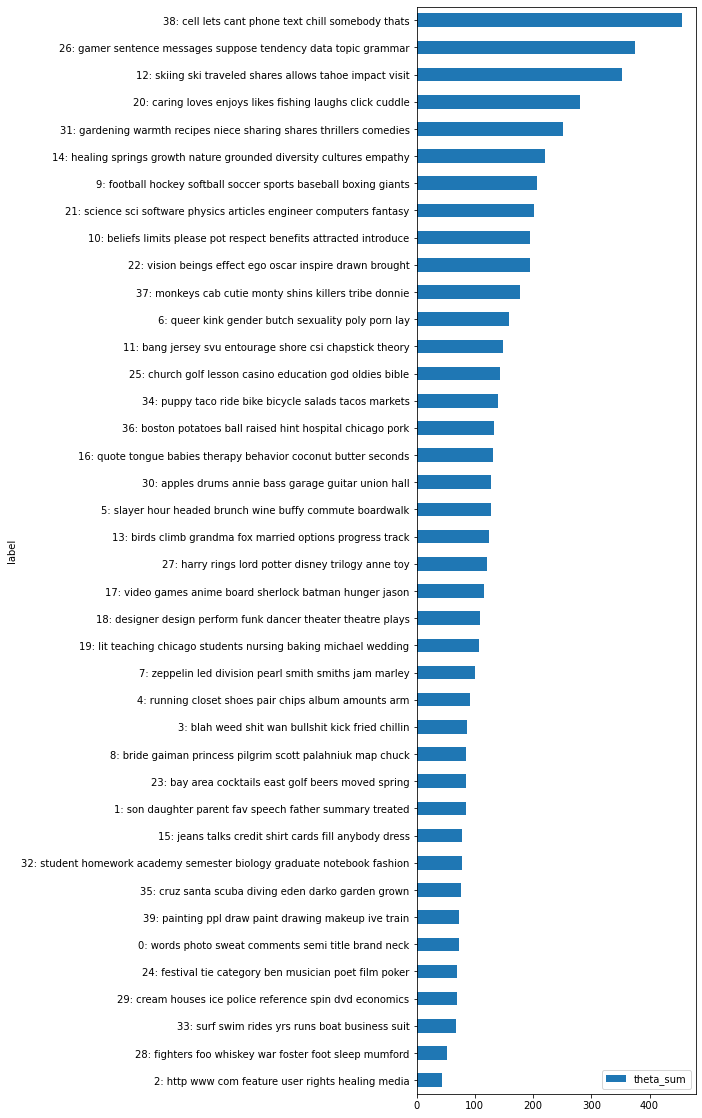

In [25]:
okc_tm.plot_topics()

In [26]:
OKC.columns

Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'ethnicity',
       'height', 'income', 'job', 'last_online', 'location', 'offspring',
       'orientation', 'pets', 'religion', 'sex', 'sign', 'smokes', 'speaks',
       'status', 'doc_raw', 'doc_clean'],
      dtype='object')

In [27]:
G = {}
for group_col in ['age','sex','income', 'status', 'orientation', 'body_type']:
    G[group_col] = okc_tm.THETA.join(OKC[group_col]).groupby(group_col).mean()

In [28]:
# AGE = tm.THETA.join(LIB['age']).groupby('age').mean()

In [29]:
G['body_type'].T.style.background_gradient(cmap='GnBu', axis=None)

body_type,a little extra,athletic,average,curvy,fit,full figured,jacked,overweight,rather not say,skinny,thin,used up
0,0.008295,0.011669,0.011627,0.013151,0.013408,0.008403,0.029005,0.017814,0.001077,0.014920,0.016061,0.023545
1,0.020481,0.011903,0.016372,0.016256,0.011469,0.016368,0.016043,0.015951,0.001077,0.023470,0.012653,0.009832
2,0.009119,0.006238,0.007011,0.006012,0.008742,0.006435,0.010640,0.006283,0.003646,0.007707,0.007938,0.014316
3,0.019004,0.015132,0.013160,0.012543,0.012880,0.009608,0.049759,0.013559,0.014505,0.018872,0.017499,0.037140
4,0.015692,0.011880,0.014765,0.018456,0.017079,0.012924,0.038306,0.007059,0.040851,0.016269,0.017971,0.021173
5,0.020699,0.024898,0.020463,0.026551,0.023901,0.024586,0.008777,0.013107,0.012679,0.016177,0.019492,0.015263
6,0.016212,0.022586,0.023819,0.036735,0.022320,0.043265,0.059761,0.034600,0.064790,0.040491,0.030166,0.062543
7,0.011002,0.013787,0.017768,0.014551,0.018777,0.008154,0.021437,0.012071,0.016872,0.019543,0.029019,0.024537
8,0.012971,0.012175,0.013350,0.019041,0.012101,0.019425,0.007015,0.026450,0.011832,0.018014,0.021468,0.004065
9,0.036590,0.057243,0.034904,0.021367,0.034485,0.023060,0.056055,0.027619,0.060086,0.029093,0.024326,0.016805


In [30]:
okc_tm.TOPIC.loc[27].top_terms_rel

'harry rings lord potter disney trilogy anne toy'

In [31]:
G['age'].T.style.background_gradient(cmap='GnBu', axis=0)

age,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69
0,0.011813,0.013572,0.010045,0.019894,0.014164,0.013266,0.008081,0.016231,0.011662,0.020942,0.008741,0.013283,0.011357,0.020839,0.012864,0.013743,0.009178,0.007630,0.010264,0.011201,0.015504,0.006391,0.010959,0.012273,0.019084,0.017733,0.009951,0.001762,0.002832,0.025369,0.005569,0.003986,0.002131,0.000941,0.011876,0.000744,0.000776,0.003878,0.008427,0.024755,0.007678,0.004770,0.000351,0.000352,0.006740,0.062299,0.002605,0.000572,0.012034,0.000437,0.000360,0.000381
1,0.009723,0.012903,0.020872,0.015973,0.025536,0.007753,0.013019,0.006221,0.008444,0.013402,0.011252,0.011575,0.008773,0.010522,0.010255,0.016867,0.008466,0.005322,0.016165,0.009884,0.006757,0.004688,0.009151,0.023429,0.019933,0.019358,0.028070,0.029333,0.025585,0.017634,0.027374,0.050187,0.029746,0.035635,0.024490,0.036016,0.011946,0.022747,0.028930,0.064837,0.037381,0.028018,0.048014,0.012801,0.007798,0.018131,0.057381,0.030444,0.000801,0.026949,0.054482,0.000381
2,0.017453,0.006252,0.009829,0.003879,0.006583,0.009061,0.009909,0.008461,0.006917,0.005132,0.007659,0.007279,0.007944,0.007049,0.007182,0.008108,0.005981,0.006920,0.006163,0.006899,0.004512,0.002739,0.004790,0.007824,0.010553,0.011884,0.000900,0.006251,0.009734,0.012996,0.002683,0.007309,0.010621,0.008471,0.000401,0.015405,0.010912,0.003330,0.004692,0.007450,0.027295,0.019079,0.010697,0.016956,0.006035,0.004392,0.000644,0.001002,0.004938,0.000437,0.014035,0.000381
3,0.015008,0.035034,0.022305,0.024734,0.014324,0.022931,0.019714,0.018006,0.024779,0.011736,0.016348,0.011156,0.015350,0.022880,0.022298,0.018215,0.013161,0.009680,0.014454,0.010791,0.007950,0.004831,0.004268,0.010459,0.004342,0.011128,0.005017,0.009913,0.008719,0.030947,0.003944,0.001495,0.005395,0.000841,0.002953,0.007456,0.000348,0.002741,0.003161,0.006006,0.007206,0.011685,0.000351,0.001180,0.000325,0.000434,0.000644,0.010911,0.012951,0.000437,0.007050,0.000381
4,0.001829,0.008920,0.013738,0.008458,0.015824,0.016808,0.011558,0.013921,0.017208,0.021070,0.015632,0.024312,0.019805,0.019556,0.015992,0.008489,0.010716,0.032305,0.013867,0.018529,0.014454,0.019315,0.014955,0.019143,0.011407,0.018054,0.010669,0.006759,0.026418,0.005542,0.020634,0.016196,0.010202,0.038711,0.002759,0.011268,0.018621,0.004704,0.010465,0.015773,0.005141,0.011843,0.000351,0.000352,0.014562,0.000434,0.010521,0.021243,0.000801,0.006054,0.017508,0.000381
5,0.005173,0.015543,0.006609,0.013401,0.006967,0.011199,0.018320,0.021742,0.028317,0.027824,0.027149,0.019761,0.023509,0.023376,0.027947,0.031439,0.037907,0.034811,0.025631,0.017678,0.024741,0.029866,0.018186,0.022341,0.030164,0.026082,0.024052,0.025242,0.022863,0.012898,0.017523,0.042021,0.012099,0.006379,0.006096,0.024739,0.005276,0.014327,0.005652,0.005895,0.037848,0.024154,0.025342,0.000352,0.013744,0.015593,0.008039,0.011219,0.019549,0.000437,0.000360,0.000381
6,0.096350,0.010810,0.018960,0.037130,0.032174,0.032351,0.032382,0.026542,0.027472,0.031692,0.037246,0.021411,0.028472,0.034950,0.032456,0.028981,0.030058,0.019129,0.032838,0.029768,0.036249,0.021086,0.013705,0.017179,0.026291,0.023106,0.026393,0.029081,0.017818,0.010845,0.020681,0.005413,0.020121,0.010343,0.021531,0.002573,0.013829,0.025431,0.019376,0.001238,0.018795,0.005894,0.003394,0.007362,0.005587,0.015193,0.000644,0.001559,0.016244,0.000437,0.000360,0.062206
7,0.039921,0.021496,0.023294,0.015507,0.021696,0.025641,0.021817,0.026584,0.019093,0.020560,0.014271,0.016184,0.016629,0.012036,0.017861,0.017592,0.015091,0.017885,0.012024,0.013010,0.015854,0.013229,0.015437,0.011715,0.015181,0.012285,0.029896,0.014786,0.033190,0.011356,0.007784,0.009731,0.012851,0.006216,0.005981,0.000744,0.002821,0.005581,0.010154,0.012792,0.005916,0.014939,0.000351,0.002165,0.000325,0.000434,0.000644,0.000572,0.000801,0.000437,0.000360,0.021220
8,0.009620,0.008333,0.013575,0.017758,0.009218,0.019598,0.013354,0.018256,0.0169

In [32]:
okc_tm.TOPIC.loc[21].top_terms_rel

'science sci software physics articles engineer computers fantasy'

In [33]:
G['status'].T.style.background_gradient(cmap='GnBu', axis=0)

status,available,married,seeing someone,single,unknown
0,0.008172,0.015830,0.012360,0.012649,0.004792
1,0.011570,0.008119,0.012167,0.014804,0.004792
2,0.011831,0.011517,0.009169,0.007085,0.004792
3,0.012078,0.020986,0.016417,0.015010,0.004792
4,0.012347,0.012002,0.020020,0.015642,0.477095
5,0.012213,0.008216,0.011369,0.023085,0.004792
6,0.101980,0.039520,0.044932,0.022975,0.004792
7,0.020858,0.012013,0.015201,0.017222,0.004792
8,0.028951,0.021941,0.019631,0.013709,0.004792
9,0.013642,0.012322,0.020598,0.037463,0.004792


In [34]:
okc_tm.TOPIC.loc[35].top_terms_rel

'cruz santa scuba diving eden darko garden grown'

# Save

In [35]:
DOCIDX = OKC_BOW2.sort_index().unstack().index

In [36]:
# OKC.loc[DOCIDX].to_csv(f"../data/okcupid/okcupid-LIB.csv")

In [37]:
# OKC_BOW2.sort_index().to_csv(f"../data/okcupid/okcupid-BOW.csv")

In [38]:
okc_tm.V.loc[B.index]

NameError: name 'B' is not defined

In [ ]:
A = OKC_BOW2.unstack(fill_value=0).iloc[:5].T.sort_index().T

In [ ]:
A

In [ ]:
B = okc_tm.PHI.T.sort_index()

In [ ]:
B

In [ ]:
A.dot(B)

In [ ]:
a